In [388]:
%matplotlib inline

import notebook
from notebook.nbextensions import enable_nbextension
enable_nbextension('notebook', 'usability/codefolding/main')
import numpy as np
from astropy.time import Time
from astropy.io import fits
import glob
import itertools
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns
import os
from scipy.optimize import curve_fit
import sys
from astropy import wcs 
from astropy.coordinates import SkyCoord
import astropy.units as u
import cStringIO
sys.path.append('/Users/vs/Dropbox/Python')

bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

In [389]:
#input_target = sys.argv[1]
#input_channel = sys.argv[2]
#catalog = sys.argv[3]

input_target = 'omegaCen_3'
input_channel = '4p5um'
#catalog = 'kaluzny2004_field1_ch1.als'
ref_image = input_target + '_e1_' + input_channel + '_dn.fits'

In [390]:
if (input_channel == '1' or input_channel == '3p6um'):
    channel = '3p6um'
if (input_channel =='2' or input_channel == '4p5um'):
    channel = '4p5um'
    
field = input_target[-1]
#print field, channel


In [391]:
path = '/Volumes/Khaleesi/CRRP/Globular_Cluster_Output/omegaCen/'+ input_target +'_'+ channel + '/' + input_target + '_e*_' + channel + '_dn.fits'
input_image_list = glob.glob(path)
input_lc_data = input_target + '_' + channel + '.cal'

mjds = np.zeros(len(input_image_list))

## Commenting this out for now - using a list of MJDS rather than reading them from headers.

for count in range(0, len(input_image_list)):
    hdulist = fits.open(input_image_list[count])
    prihdr = hdulist[0].header
    date_obs = Time(prihdr['date_obs'])
    mjds[count] = date_obs.mjd

## Get the mjds from these files - only applicable to omega cen data

#mjd_file = input_target + '_' + channel + '.mjds'
#poch_num, mjds = np.loadtxt(mjd_file, unpack=True)

#epoch1_ids, kal_ids = np.loadtxt(input_target + '_' + channel + '_rrl.tfr', skiprows=14, usecols=(0, 15), unpack=True)
#k_xc, k_yc, periods, k_ids = np.loadtxt(catalog, usecols=(1,2,4,5), unpack=True)

if ((len(mjds) % 6 ) == 0):
    n_lines_raw = int((len(mjds) / 6) + 1)
else:
    n_lines_raw = int(np.ceil(len(mjds)) / 6 + 1)

with open(input_lc_data) as input:
    lines = []
    while True:
        line = list(itertools.islice(input, n_lines_raw))
        if line:
            lines.append(line)
        else:
            break


num_stars = len(lines)
num_frames = len(mjds)
objects = np.zeros((num_stars, (num_frames*2) + 3))
for star in np.arange(0,num_stars):
    data = "".join(lines[star])
    data = data.split()
    objects[star][0] = data[0] ## ID
    objects[star][1] = data[1] ## XC
    objects[star][2] = data[2] ## YC
    for epoch in np.arange(0,(num_frames*2), 2):
        objects[star][epoch + 3]  = data[epoch + 3] ## mag
        objects[star][epoch + 4] = data[epoch + 4] ## err
        


In [392]:
cols = ['als_id', 'xc', 'yc'] 

for epochs in np.arange(len(mjds)):
    mag_name = ('mag_' + str(epochs+1))
    err_name = ('err_' + str(epochs+1))
    cols.append(mag_name)
    cols.append(err_name)

cols

input_lc_df = pd.DataFrame(objects, columns=cols)

In [393]:
input_lc_df

,als_id,xc,yc,mag_1,err_1,mag_2,err_2,mag_3,err_3,mag_4,...,mag_8,err_8,mag_9,err_9,mag_10,err_10,mag_11,err_11,mag_12,err_12
0,17645.0,946.638,25.300,16.324,0.097,15.783,0.092,15.670,0.084,15.795,...,16.213,0.087,16.114,0.084,16.115,0.081,16.055,0.092,16.066,0.096
1,17205.0,927.675,25.378,17.060,0.130,17.136,0.179,16.994,0.149,16.978,...,16.740,0.131,16.701,0.111,16.839,0.120,16.682,0.134,16.889,0.106
2,17353.0,934.041,25.486,16.287,0.117,16.100,0.099,16.114,0.075,16.154,...,16.235,0.123,16.043,0.097,16.151,0.113,16.131,0.092,16.148,0.102
3,18661.0,1014.054,25.702,16.848,0.070,16.595,0.084,16.641,0.077,16.438,...,16.635,0.087,16.968,0.098,16.881,0.092,16.774,0.068,16.699,0.050
4,20051.0,1100.878,25.776,16.887,0.099,16.621,0.106,16.963,0.114,16.585,...,16.921,0.073,17.119,0.110,16.991,0.089,16.810,0.094,16.941,0.083
5,16616.0,889.281,26.395,15.174,0.072,14.905,0.092,15.277,0.077,15.292,...,15.215,0.104,15.212,0.101,15.269,0.097,15.230,0.092,15.170,0.094
6,16873.0,904.781,26.632,17.257,0.099,16.936,0.117,17.607,0.205,17.754,...,17.900,0.202,17.851,0.171,17.185,0.116,17.859,0.313,17.399,0.201
7,19914.0,1092.273,26.862,17.695,0.142,17.058,0.128,17.425,0.101,17.141,...,17.794,0.117,17.366,0.112,17.242,0.105,17.590,0.127,17.423,0.152
8,21473.0,1211.814,27.227,16.868,0.127,16.747,0.149,16.937,0.141,16.519,...,16.869,0.138,16.826,0.153,16.885,0.112,16.745,0.156,16.763,0.114
9,22156.0,1262.384,28.312,14.080,0.083,13.959,0.091,14.140,0.107,14.574,...,14.108,0.083,14.092,0.085,14.037,0.075,14.037,0.089,14.086,0.090


In [394]:
hdulist = fits.open(ref_image)
w = wcs.WCS(hdulist[0].header)
coords = SkyCoord(ra=kaluzny.RA, dec=kaluzny.Dec, frame='icrs', unit=(u.hour, u.deg))
kaluzny['xc'], kaluzny['yc'] = wcs.utils.skycoord_to_pixel(coords, w, 0, 'all')
image_range = hdulist[0].data.shape
hdulist.close()

image_limit_x = image_range[1]
image_limit_y = image_range[0]

In [395]:
image_range

(691, 1408)

In [396]:
kaluzny

,ID,RA,Dec,Period,Vmag,Type,xc,yc,als_id,distance
0,V3,13:25:56.15,-47:25:53.8,0.841258,14.01,RR0,254.940663,1053.031789,12180.0,1.415681
1,V4,13:26:12.93,-47:24:18.8,0.627320,13.83,RR0,-56.382072,959.676736,5484.0,1.423079
2,V5,13:26:18.33,-47:23:12.4,0.515274,14.00,RR0,-199.444965,971.116652,2376.0,1.449199
3,V7,13:27:00.90,-47:14:00.5,0.713000,14.08,RR0,-1362.281292,1091.975056,-1.0,-1.000000
4,V8,13:27:48.45,-47:28:20.3,0.521329,13.90,RR0,-888.400042,-482.033419,-1.0,-1.000000
5,V9,13:25:59.58,-47:26:24.0,0.523480,14.10,RR0,250.621089,976.357730,12083.0,1.200340
6,V10,13:26:06.99,-47:24:36.6,0.374976,14.31,RR1,34.895376,1011.142506,7290.0,5.137990
7,V11,13:26:30.59,-47:23:01.6,0.564789,14.20,RR0,-356.769966,834.601574,-1.0,-1.000000
8,V12,13:26:27.21,-47:24:06.2,0.386769,14.32,RR1,-239.632074,800.795942,1548.0,1.942166
9,V13,13:25:58.18,-47:25:21.6,0.669039,13.92,RR0,192.526081,1065.807311,10932.0,1.312612


In [397]:
als_file = input_target + '_e1_' + channel + '_dn.cal'
als_df = pd.read_csv(als_file, delim_whitespace=True, header=None, names=('als_id', 'xc', 'yc', 'mag', 'err', 'lcorr'))

In [398]:
als_df

,als_id,xc,yc,mag,err,lcorr
0,178,29.06,180.94,12.041,0.064,1.016
1,6184,362.62,98.83,15.965,0.186,1.013
2,18090,975.47,351.40,20.003,0.498,1.020
3,22472,1293.19,565.80,17.092,0.072,0.922
4,8762,500.80,57.52,16.490,0.099,0.993
5,3753,231.29,75.04,11.257,0.050,1.013
6,1210,92.73,200.06,14.496,0.097,1.015
7,19907,1093.86,282.59,17.264,0.057,1.014
8,22532,1300.40,552.20,16.820,0.068,0.922
9,4751,288.83,51.35,14.247,0.101,1.012


In [399]:
matched = np.ones(len(kaluzny))*-1
matched

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [400]:
### Brute force matching because daomaster hates me.
### Putting a hard limit on selecting matches within 10 pixles
curr_dir = os.getcwd().split('/')[-1]
new_dir = input_target + '_' + channel + '_plots'
is_there = os.path.exists(new_dir)
if (curr_dir != new_dir):
    if (is_there == False):
        os.mkdir(new_dir)

## Search for the matches

matched = np.ones(len(kaluzny))*-1
good_distance = np.ones(len(kaluzny))*-1

for rrl in np.arange(len(kaluzny)):
    best_distance = 100
    for test_star in np.arange(len(als_df)):
        if (kaluzny.xc[rrl] < image_limit_x and kaluzny.xc[rrl] > 0 and kaluzny.yc[rrl] < image_limit_y and kaluzny.yc[rrl] > 0):
            x_distance = kaluzny.xc[rrl] - als_df.xc[test_star]
            y_distance = kaluzny.yc[rrl] - als_df.yc[test_star]
            distance = np.sqrt(x_distance**2 + y_distance**2)
            if distance < best_distance:
                best_distance = distance
                best_match = test_star
    if best_distance < 10:
        matched[rrl] = als_df.als_id[best_match]
        good_distance[rrl] = best_distance
    best_distance = 100
        

In [401]:
## converting the matched and good_distance lists to data frames for combining with the kaluzny data frame

matched_df = pd.DataFrame(matched)
distance_df = pd.DataFrame(good_distance)

In [402]:
### als_id = -1 means it didn't match with the required limits
### distance is the distance in pixels between the predicted pixel position from the kaluzny catalogue and the observed position
## 1 pixel = 0.6 arcsec
kaluzny['als_id'] = matched_df
kaluzny['distance'] = distance_df

In [403]:
kaluzny

,ID,RA,Dec,Period,Vmag,Type,xc,yc,als_id,distance
0,V3,13:25:56.15,-47:25:53.8,0.841258,14.01,RR0,254.940663,1053.031789,-1.0,-1.000000
1,V4,13:26:12.93,-47:24:18.8,0.627320,13.83,RR0,-56.382072,959.676736,-1.0,-1.000000
2,V5,13:26:18.33,-47:23:12.4,0.515274,14.00,RR0,-199.444965,971.116652,-1.0,-1.000000
3,V7,13:27:00.90,-47:14:00.5,0.713000,14.08,RR0,-1362.281292,1091.975056,-1.0,-1.000000
4,V8,13:27:48.45,-47:28:20.3,0.521329,13.90,RR0,-888.400042,-482.033419,-1.0,-1.000000
5,V9,13:25:59.58,-47:26:24.0,0.523480,14.10,RR0,250.621089,976.357730,-1.0,-1.000000
6,V10,13:26:06.99,-47:24:36.6,0.374976,14.31,RR1,34.895376,1011.142506,-1.0,-1.000000
7,V11,13:26:30.59,-47:23:01.6,0.564789,14.20,RR0,-356.769966,834.601574,-1.0,-1.000000
8,V12,13:26:27.21,-47:24:06.2,0.386769,14.32,RR1,-239.632074,800.795942,-1.0,-1.000000
9,V13,13:25:58.18,-47:25:21.6,0.669039,13.92,RR0,192.526081,1065.807311,-1.0,-1.000000


In [404]:
### Total number of RRL matched in this field/channel combo
sum(kaluzny.als_id>0)

29

In [405]:
## Setting up the output file name
outfile = input_target + '_' + channel + '_rrl' + '_matched_to_kaluzny.cal'
print outfile


omegaCen_3_4p5um_rrl_matched_to_kaluzny.cal


In [406]:
## matching the data frames on als_id

merged_tables = als_df.merge(kaluzny, on='als_id')
merged_tables = merged_tables.drop(['xc_y', 'yc_y'], 1)
merged_tables.rename(columns={'xc_x':'xc', 'yc_x': 'yc'}, inplace=True)

In [407]:
merged_tables

,als_id,xc,yc,mag,err,lcorr,ID,RA,Dec,Period,Vmag,Type,distance
0,6946,406.91,216.59,13.320,0.068,1.016,V120,13:26:25.52,-47:32:48.6,0.548537,14.20,RR0,1.670601
1,1163,89.55,523.95,13.180,0.096,1.003,V25,13:26:25.52,-47:28:23.3,0.588364,13.93,RR0,1.699094
2,2255,147.05,370.54,13.685,0.099,1.019,NV339,13:26:29.67,-47:29:51.8,0.301322,14.44,RR1,1.875871
3,11972,648.21,412.68,12.982,0.077,0.970,V34,13:26:07.21,-47:33:10.4,0.733967,14.05,RR0,1.577264
4,20937,1165.79,86.82,13.499,0.044,0.997,V14,13:25:59.74,-47:39:09.6,0.377114,14.29,RR1,2.345988
5,10332,571.38,130.22,14.055,0.054,0.986,V44,13:26:22.39,-47:34:35.3,0.567545,14.17,RR0,1.406739
6,1727,121.07,431.26,8.872,0.062,1.014,V135,13:26:28.14,-47:29:17.6,0.632579,14.03,RR0,3.055790
7,20230,1113.17,237.07,13.262,0.035,1.012,V56,13:25:55.53,-47:37:44.1,0.568023,14.30,RR0,2.528496
8,1932,128.66,378.92,13.917,0.072,1.017,V131,13:26:30.07,-47:29:40.7,0.392252,14.29,RR1,1.603076
9,4485,271.59,369.22,13.918,0.074,1.021,V40,13:26:24.56,-47:30:46.2,0.634072,13.88,RR0,1.227458


In [408]:
## Print to file
merged_tables.to_csv(outfile, sep='\t', header=True, index=False)

In [409]:
### Now can I match the lc data frame to the kaluzny file too??

huge_df = merged_tables.merge(input_lc_df, on='als_id')
#huge_df = huge_df.drop(['xc_y', 'yc_y'], 1)
huge_df = huge_df.rename(columns={'xc_y':'xc_lc', 'yc_y': 'yc_lc'})
huge_df = huge_df.rename(columns={'xc_x':'xc_ref', 'yc_x': 'yc_ref'})


In [410]:
### YES. YES I CAN.
huge_df

,als_id,xc_ref,yc_ref,mag,err,lcorr,ID,RA,Dec,Period,...,mag_8,err_8,mag_9,err_9,mag_10,err_10,mag_11,err_11,mag_12,err_12
0,6946,406.91,216.59,13.320,0.068,1.016,V120,13:26:25.52,-47:32:48.6,0.548537,...,13.190,0.053,13.215,0.077,13.151,0.075,13.117,0.083,13.152,0.078
1,1163,89.55,523.95,13.180,0.096,1.003,V25,13:26:25.52,-47:28:23.3,0.588364,...,13.131,0.088,13.163,0.080,13.332,0.093,13.378,0.086,13.262,0.104
2,2255,147.05,370.54,13.685,0.099,1.019,NV339,13:26:29.67,-47:29:51.8,0.301322,...,13.624,0.074,13.428,0.075,13.656,0.115,13.968,0.133,13.766,0.127
3,11972,648.21,412.68,12.982,0.077,0.970,V34,13:26:07.21,-47:33:10.4,0.733967,...,13.181,0.080,13.225,0.073,13.172,0.086,12.922,0.069,12.871,0.070
4,20937,1165.79,86.82,13.499,0.044,0.997,V14,13:25:59.74,-47:39:09.6,0.377114,...,13.388,0.040,13.401,0.037,13.452,0.035,13.480,0.033,13.384,0.029
5,10332,571.38,130.22,14.055,0.054,0.986,V44,13:26:22.39,-47:34:35.3,0.567545,...,13.761,0.069,13.777,0.053,13.851,0.056,13.950,0.062,13.910,0.075
6,20230,1113.17,237.07,13.262,0.035,1.012,V56,13:25:55.53,-47:37:44.1,0.568023,...,13.567,0.025,13.444,0.036,13.331,0.039,13.317,0.029,13.343,0.030
7,1932,128.66,378.92,13.917,0.072,1.017,V131,13:26:30.07,-47:29:40.7,0.392252,...,13.741,0.056,13.830,0.070,13.867,0.091,13.847,0.068,13.976,0.079
8,4485,271.59,369.22,13.918,0.074,1.021,V40,13:26:24.56,-47:30:46.2,0.634072,...,13.594,0.066,13.618,0.081,13.752,0.120,13.655,0.057,13.633,0.058
9,18202,982.67,75.40,13.164,0.025,1.016,V49,13:26:07.78,-47:37:55.5,0.604627,...,13.266,0.033,13.354,0.054,13.259,0.056,13.245,0.049,13.256,0.045


In [411]:
curr_dir = os.getcwd().split('/')[-1]
new_dir = input_target + '_' + channel + '_plots'
is_there = os.path.exists(new_dir)
if (curr_dir != new_dir):
    if (is_there == False):
        os.mkdir(new_dir)

### Now making the lightcurves should be a piece of piss. Right??

## Grab the corresponding mag data, and plot away...
lc_mag_columns = []
lc_err_columns = []
for epochs in np.arange(len(mjds)):
    mag_name = ('mag_' + str(epochs+1))
    err_name = ('err_' + str(epochs+1))
    lc_mag_columns.append(mag_name)
    lc_err_columns.append(err_name)

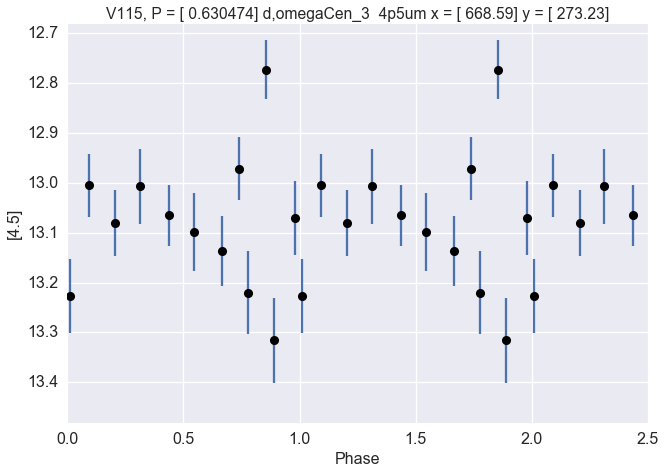

In [412]:
for rrl in np.arange(len(huge_df)):
    kal_id = huge_df.ID[rrl]
    shp = int(mjds.shape[0])
    mag = huge_df[lc_mag_columns].loc[huge_df['ID'] == kal_id].values.reshape(shp)
    err = huge_df[lc_err_columns].loc[huge_df['ID'] == kal_id].values.reshape(shp)
    period = huge_df.Period.loc[huge_df['ID'] == kal_id].values
    xc = huge_df.xc_ref.loc[huge_df['ID'] == kal_id].values
    yc = huge_df.yc_ref.loc[huge_df['ID'] == kal_id].values
 
    idx = np.argsort(mjds)
    mjds = mjds[idx]
    mag = mag[idx]
    err = err[idx]
    phase = (mjds / period) - np.floor(mjds / period)
    phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))
    
    mag_long  = np.concatenate((mag, mag, mag, mag, mag))
    
    err_long = np.concatenate((err, err, err, err, err))
    obs = np.arange(1, num_frames+1, 1)


    output = str(kal_id) + '_rrlyrae.data'
    output_file = open(new_dir + '/' + output, "w")

    for frame in np.arange(0, num_frames):
        output_file.write("{0:.8f} {1:.3f} {2:.3f} \n".format(mjds[frame], mag[frame], err[frame]))
    
    output_file.close()
    ## Sanity check plot

    mp.close()
    mp.clf()
    axp1 = mp.subplot(111)

    axp1.axis([0,2.5,(np.average(mag) + 0.4),(np.average(mag) - 0.4)])


    axp1.errorbar(phase, mag_long, yerr=err_long, ls='None')
    axp1.plot(phase, mag_long, 'ko', ls='None')
    mp.xlabel("Phase")
    if (channel == '3p6um'): mp.ylabel('[3.6]')
    if (channel == '4p5um'): mp.ylabel('[4.5]')
    mp.title(kal_id + ', P = ' + str(period) +' d,' + input_target + '  ' + channel + ' x = ' + str(xc) + ' y = ' +  str(yc))
    #mp.show()

    mp.savefig(new_dir + '/' + str(kal_id) + '_F' + field + '_' + channel +'.pdf')

    #mp.close()
   

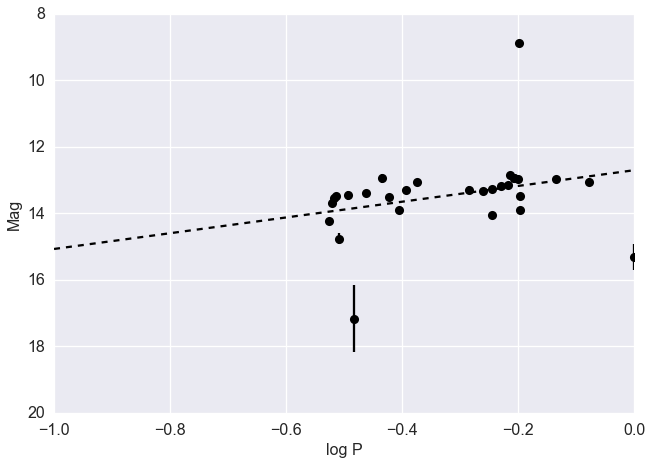

In [413]:

### Doing some quality checks on the matching
mp.close()
mp.clf()
axp1 = mp.subplot(111)

lp1 = np.arange(-1., 1, 1)
def pl1(logp, zp):
    return -2.355 * logp + zp

merged_tables['logP'] = np.log10(merged_tables.Period)
#merged_tables.logP[np.where(merged_tables['Type']=='RR1')] = np.log10(merged_tables.Period) + 0.127

#merged_tables['logP'][np.where(merged_tables['Type']=='RR1')] = merged_tables['logP'] + 0.127

popt, pcov = curve_fit(pl1,merged_tables.logP,merged_tables.mag)
zp = popt[0]
ezp = np.sqrt(float(pcov[0]))

mp.gca().invert_yaxis()
mp.xlabel('log P')
mp.ylabel('Mag')
axp1.errorbar(merged_tables.logP, merged_tables.mag, yerr=merged_tables.err, color='k', ls='none')
axp1.plot(merged_tables.logP, merged_tables.mag, 'ko')
axp1.plot(lp1, -2.370*lp1 + zp, 'k--')
